In [1]:
import psrchive
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
def Read_File(file_path, dedisperse = True):
    File = psrchive.Archive_load(file_path)
    File.tscrunch()
    if dedisperse == True:
        File.dedisperse()
    File.pscrunch()
    File.remove_baseline()
    dm = File.get_dispersion_measure()
    center_freq = File.get_centre_frequency()
    integration = File.get_first_Integration()
    period = integration.get_folding_period()
    File_Data = File.get_data()
    pulse = File_Data[0,0,:] #Select usable part of data
    
    #Get a list of the frequencies
    freq_mhz_table = File.get_frequency_table()
    freq_mhz = freq_mhz_table[0]
    
    
    return(pulse, freq_mhz, dm, center_freq, period)

In [3]:
file_path = '/srv/storage_11/galc/UBB/jtremblay/20231227/singlepulse/search1/pulse_3430703646.ar'
training_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = True)

In [4]:
#Create cleaned data
train_RFI_chns = [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 58, 59, 60, 61, 63, 64, 66, 53, 72, 83, 73, 78, 499, 451, 388, 211, 212, 213, 214, 215, 216, 217, 218, 219, 229, 210, 220, 209, 137, 138, 94, 99, 100, 101, 102, 103, 104, 98, 105, 106, 97, 107, 95, 96, 108, 109, 0]

# Create a boolean mask with True for indices to exclude
# mask_train = np.full_like(training_data, True, dtype=bool)
# mask_train[train_RFI_chns] = False

# Use the mask to select all values except those at specified indices
# training_data_no_RFI = training_data[mask_train]

Need to create two lists where one list is all the data and the second list is a list of true or false where true is good data and false is bad data.

In [5]:
true_values_train = [True] * len(training_data)
train_targets = [False if i in train_RFI_chns else value for i, value in enumerate(true_values_train)]

In [6]:
# X_train hold the features for training = all data (arrays of frequency) = what we learn from
# y_train hold the targets = what we want to predict = what we want to learn = True/False depending on if the corresponding array should be removed or not
# X_test = features that we will input in the model
# y_test = GROUND TRUTH = what we will compare the predictions with to compute accuracy
X_train, X_test, y_train, y_test = train_test_split(training_data, train_targets, test_size=0.2)

In [7]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [8]:
accuracy_score(y_test, predictions)

0.9514563106796117

Now we try to test on independent data so we will clean another file manually to create another file of true and false values

In [9]:
file_path = '/srv/storage_11/galc/UBB/jtremblay/20231227/singlepulse/search1/pulse_3430703647.ar'
test_data, freq_mhz, dm, center_freq, period = Read_File(file_path, dedisperse = True)

In [10]:
print(np.shape(test_data))

(512, 1024)


In [11]:
test_RFI_chns = [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 499, 451, 55, 58, 60, 61, 63, 64, 66, 68, 388, 210, 211, 212, 213, 214, 215, 216, 217, 218, 229, 137, 138, 136, 98, 99, 100, 101, 102, 103, 104, 105, 106, 94, 83, 95, 96, 97, 107, 0]

In [12]:
# Create a boolean mask with True for indices to exclude
# mask_test = np.full_like(test_data, True, dtype=bool)
# mask_test[test_RFI_chns] = False

# Use the mask to select all values except those at specified indices
# test_data_no_RFI = test_data[mask_test]

true_values_test = [True] * len(test_data)
test_targets = [False if i in test_RFI_chns else value for i, value in enumerate(true_values_test)]

In [13]:
X_train = training_data
X_test = test_data
y_train = train_targets
y_test = test_targets

In [14]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [15]:
accuracy_score(y_test, predictions)

0.9375

In [16]:
# Identify indices where array2 is False
false_indices = np.where(predictions == False)[0]

# Set values to NaN for the corresponding rows in array1
test_data[false_indices, :] = np.nan

In [17]:
# Check for NaN values
nan_mask = np.isnan(test_data)
np.nansum(nan_mask) / np.prod(test_data.shape) * 100

8.59375

In [18]:
print(np.shape(test_data))
print(test_data)

(512, 1024)
[[ 2.35060137e-03 -7.18896219e-04 -9.36669239e-04 ...  8.62354320e-03
  -2.70804483e-03 -2.59245653e-03]
 [ 1.15301332e-03 -9.17085636e-05 -2.57709355e-04 ...  1.68061524e-04
   3.58908146e-04 -2.13270367e-04]
 [-1.30016473e-03 -9.33031784e-04  1.07814628e-03 ... -7.27794366e-04
  -1.01573509e-03 -9.97458192e-05]
 ...
 [ 5.65789305e-02  1.54763043e-01 -5.89982904e-02 ...  6.63016438e-02
  -7.85428882e-02  1.17863715e-01]
 [-3.59851606e-02 -5.29953726e-02  1.75340883e-02 ... -1.60795934e-02
  -6.29927367e-02  2.07556002e-02]
 [-2.81292461e-02 -1.39160782e-01  3.36944431e-01 ... -3.68815921e-02
   2.41612285e-01  2.93644406e-02]]


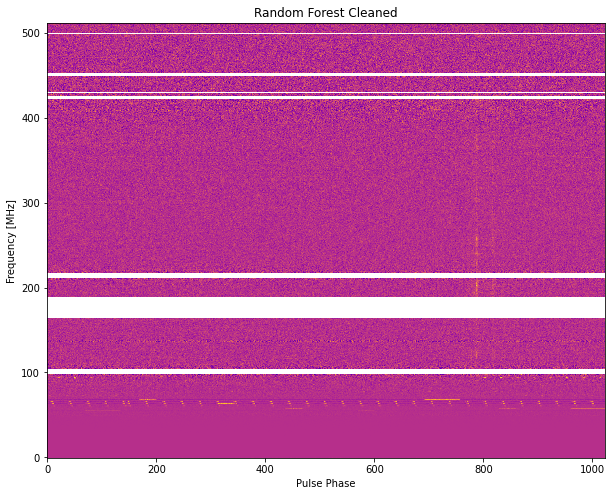

In [19]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(10)
plt.imshow(test_data, aspect='auto', cmap=plt.get_cmap('plasma'), interpolation='none', origin='lower')
plt.title('Random Forest Cleaned')
plt.ylabel('Frequency [MHz]')
plt.xlabel('Pulse Phase')
plt.show()